# SPY Regime Indicators Analysis (2015-2025)

**Objective:** Identify market regimes using multiple technical indicators

**Indicators:**
1. RSI (Relative Strength Index)
2. Distance from 52-week high
3. Rolling drawdown
4. Bollinger Bands position
5. ATR (Average True Range) - volatility
6. Rate of Change (ROC)

---

In [18]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

plt.rcParams['figure.figsize'] = (24, 16)
plt.rcParams['font.size'] = 11
plt.rcParams['lines.linewidth'] = 2

print("✓ Imports complete")

✓ Imports complete


## 1. Fetch Data

In [19]:
# Fetch SPY and VIX data
print("Fetching SPY and VIX data...")

start_date = "2015-01-01"
end_date = "2025-10-31"

spy = yf.download("SPY", start=start_date, end=end_date, progress=False, auto_adjust=False)
vix = yf.download("^VIX", start=start_date, end=end_date, progress=False, auto_adjust=False)

# Flatten multi-index if present
if isinstance(spy.columns, pd.MultiIndex):
    spy.columns = spy.columns.get_level_values(0)
if isinstance(vix.columns, pd.MultiIndex):
    vix.columns = vix.columns.get_level_values(0)

print(f"✓ Fetched {len(spy)} days of data")
spy.head()

Fetching SPY and VIX data...
✓ Fetched 2724 days of data


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2015-01-02,171.093674,205.429993,206.880005,204.179993,206.380005,121465900
2015-01-05,168.003784,201.720001,204.369995,201.350006,204.169998,169632600
2015-01-06,166.421371,199.820007,202.720001,198.860001,202.089996,209151400
2015-01-07,168.495209,202.309998,202.720001,200.880005,201.419998,125346700
2015-01-08,171.485138,205.899994,206.160004,203.990005,204.009995,147217800


## 2. Calculate Technical Indicators

In [20]:
# Calculate RSI
def calculate_rsi(data, window=14):
    """Calculate Relative Strength Index"""
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate all indicators
spy['RSI'] = calculate_rsi(spy['Close'], window=14)

# Distance from 52-week high
spy['52W_High'] = spy['Close'].rolling(window=252).max()
spy['Distance_from_52W_High'] = (spy['Close'] - spy['52W_High']) / spy['52W_High'] * 100

# Rolling drawdown
spy['Running_Max'] = spy['Close'].cummax()
spy['Drawdown'] = (spy['Close'] - spy['Running_Max']) / spy['Running_Max'] * 100

# Bollinger Bands
spy['BB_Middle'] = spy['Close'].rolling(window=20).mean()
spy['BB_Std'] = spy['Close'].rolling(window=20).std()
spy['BB_Upper'] = spy['BB_Middle'] + (2 * spy['BB_Std'])
spy['BB_Lower'] = spy['BB_Middle'] - (2 * spy['BB_Std'])
spy['BB_Position'] = (spy['Close'] - spy['BB_Lower']) / (spy['BB_Upper'] - spy['BB_Lower']) * 100

# ATR (Average True Range)
spy['TR'] = np.maximum(
    spy['High'] - spy['Low'],
    np.maximum(
        abs(spy['High'] - spy['Close'].shift(1)),
        abs(spy['Low'] - spy['Close'].shift(1))
    )
)
spy['ATR'] = spy['TR'].rolling(window=14).mean()
spy['ATR_Pct'] = spy['ATR'] / spy['Close'] * 100

# Rate of Change (ROC)
spy['ROC_20'] = (spy['Close'] / spy['Close'].shift(20) - 1) * 100
spy['ROC_60'] = (spy['Close'] / spy['Close'].shift(60) - 1) * 100

# 200 SMA for reference
spy['SMA_200'] = spy['Close'].rolling(window=200).mean()
spy['Distance_from_200SMA'] = (spy['Close'] - spy['SMA_200']) / spy['SMA_200'] * 100

# Add VIX
spy['VIX'] = vix['Close']

print("✓ All indicators calculated")
print()
print("Available indicators:")
print("  - RSI (14-day)")
print("  - Distance from 52-week high (%)")
print("  - Drawdown from running max (%)")
print("  - Bollinger Band position (%)")
print("  - ATR % (volatility)")
print("  - Rate of Change 20/60-day (%)")
print("  - VIX")

spy[['Close', 'RSI', 'Distance_from_52W_High', 'Drawdown', 'BB_Position', 'ATR_Pct', 'VIX']].tail(10)

✓ All indicators calculated

Available indicators:
  - RSI (14-day)
  - Distance from 52-week high (%)
  - Drawdown from running max (%)
  - Bollinger Band position (%)
  - ATR % (volatility)
  - Rate of Change 20/60-day (%)
  - VIX


Price,Close,RSI,Distance_from_52W_High,Drawdown,BB_Position,ATR_Pct,VIX
Date,,,,,,,
2025-10-17,664.390015,50.627563,-1.295475,-1.295475,46.618078,1.220239,20.780001
2025-10-20,671.299988,54.198112,-0.268901,-0.268901,79.186152,1.237259,18.230000
2025-10-21,671.289978,52.418238,-0.270388,-0.270388,76.440698,1.202163,17.870001
2025-10-22,667.799988,48.844410,-0.788875,-0.788875,58.534742,1.260964,18.600000
2025-10-23,671.760010,51.949835,-0.200558,-0.200558,75.281489,1.257678,17.299999
2025-10-24,677.250000,54.118010,0.000000,0.000000,95.427712,1.283447,16.370001
2025-10-27,685.239990,60.894854,0.000000,0.000000,113.217049,1.299441,15.790000
2025-10-28,687.059998,59.713157,0.000000,0.000000,106.301747,1.295894,16.420000
2025-10-29,687.390015,61.561525,0.000000,0.000000,98.380034,1.317094,16.920000


## 3. Comprehensive Visualization

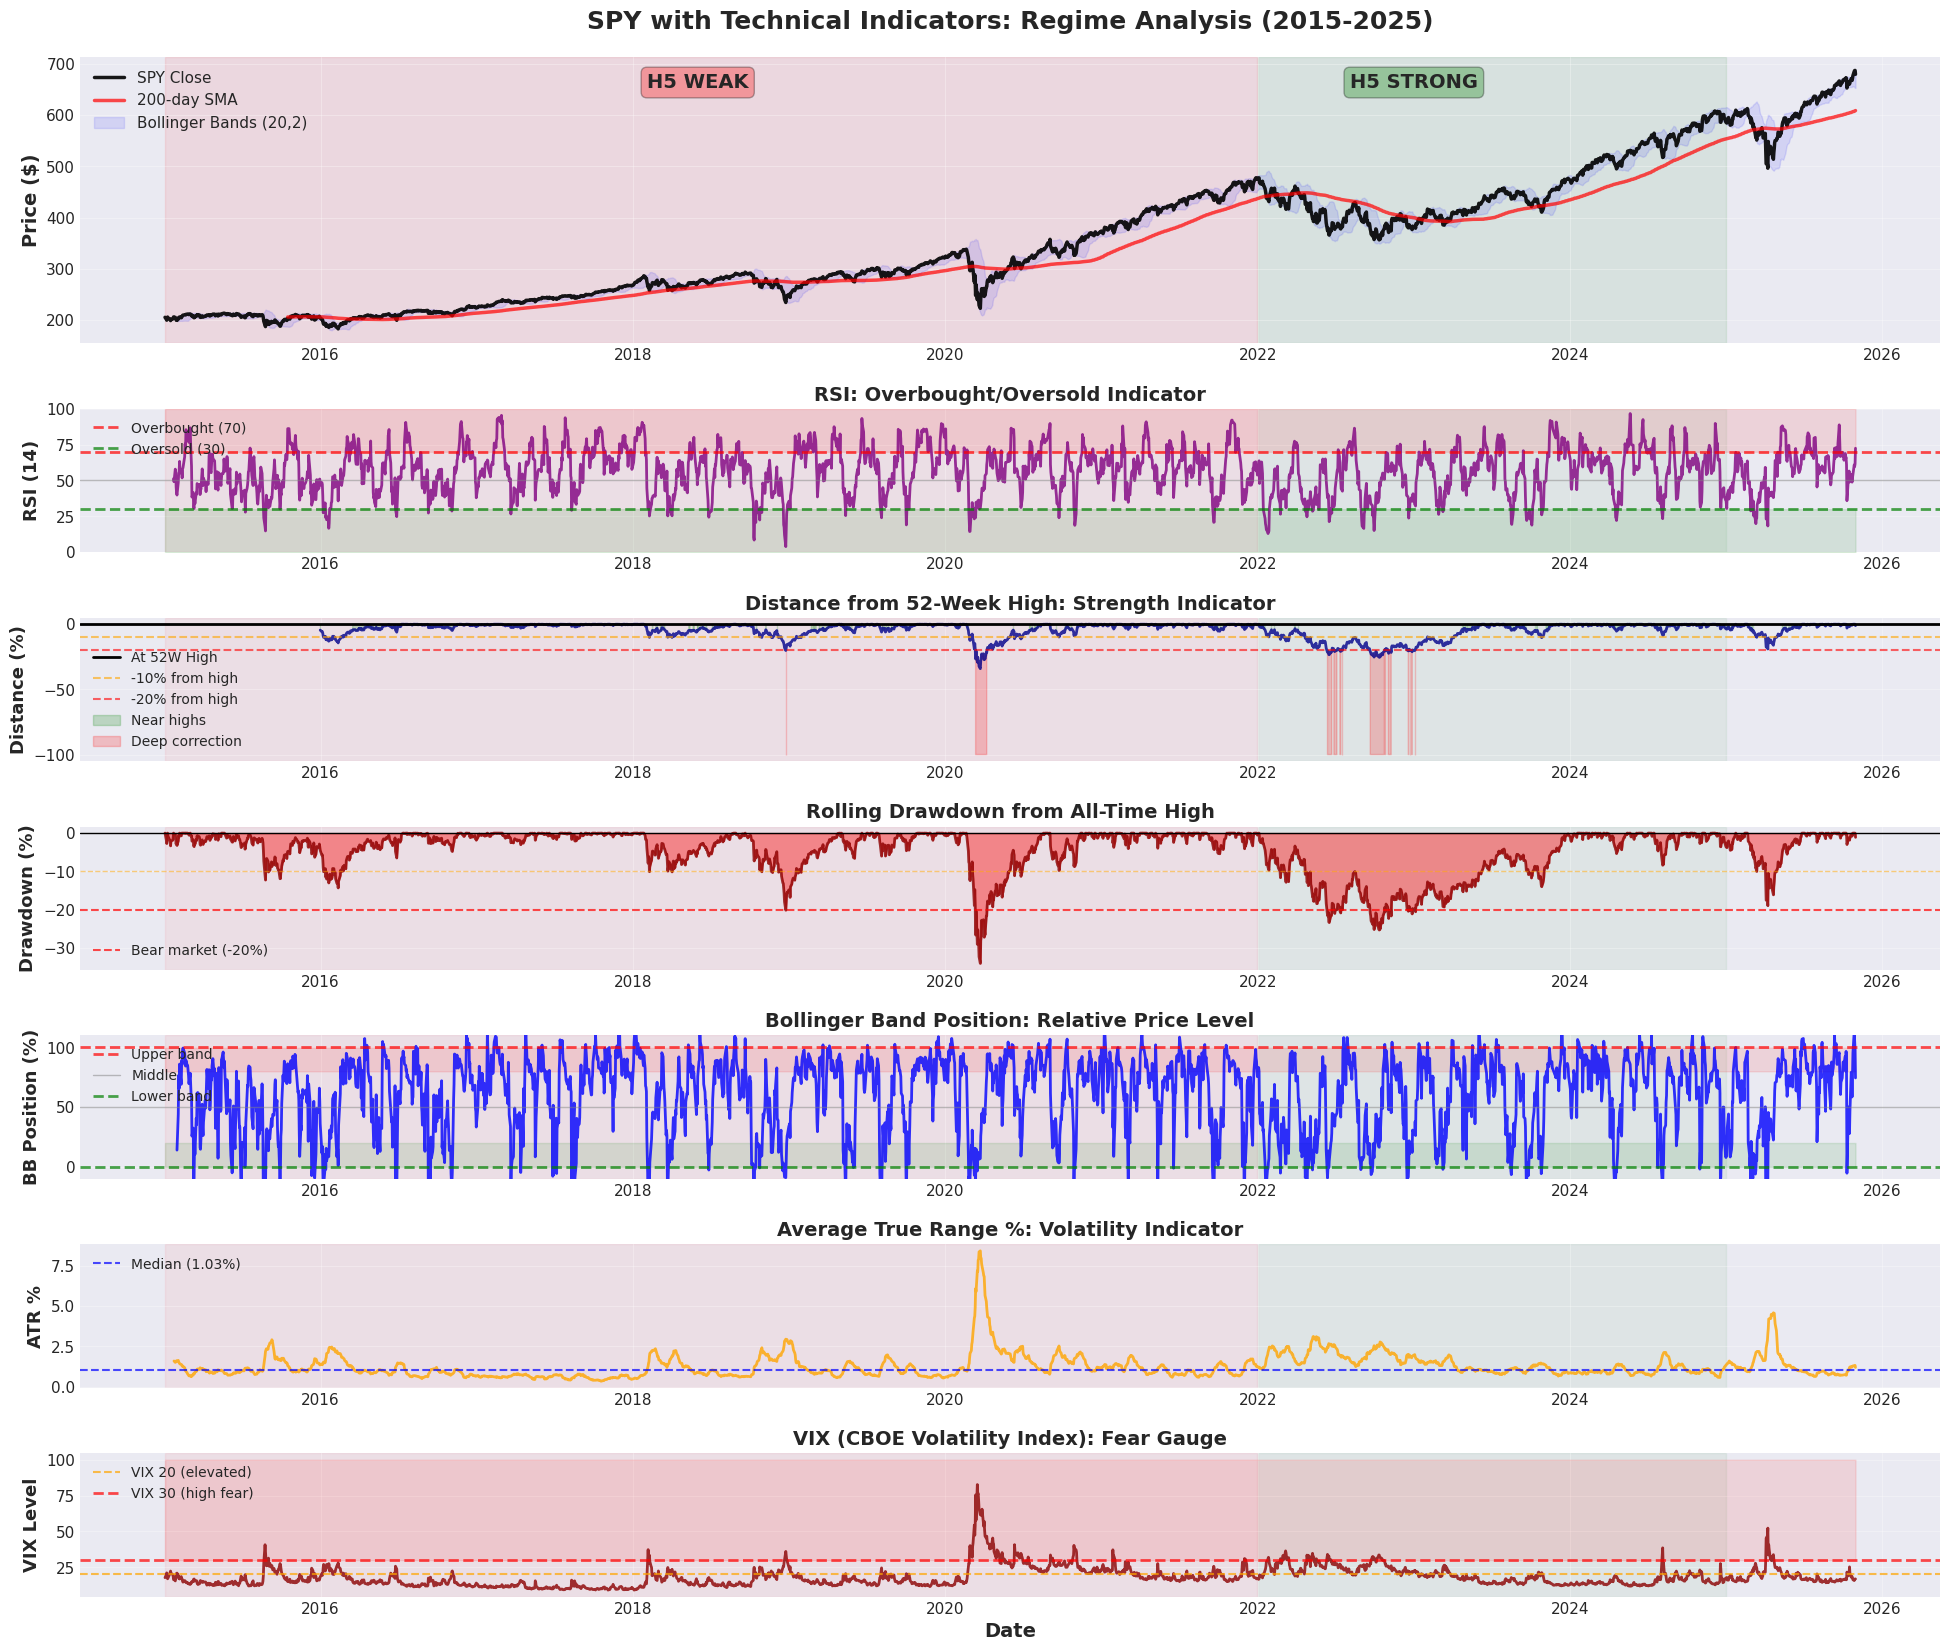

In [21]:
# Create comprehensive multi-indicator chart
fig = plt.figure(figsize=(24, 20))
gs = fig.add_gridspec(7, 1, hspace=0.4, height_ratios=[2, 1, 1, 1, 1, 1, 1])

# Define H5 periods for shading
h5_weak_start = datetime(2015, 1, 1)
h5_weak_end = datetime(2021, 12, 31)
h5_strong_start = datetime(2022, 1, 1)
h5_strong_end = datetime(2024, 12, 31)

# Plot 1: SPY Price with 200 SMA
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(spy.index, spy['Close'], linewidth=2.5, color='black', label='SPY Close', alpha=0.9)
ax1.plot(spy.index, spy['SMA_200'], linewidth=2.5, color='red', label='200-day SMA', alpha=0.7)
ax1.fill_between(spy.index, spy['BB_Lower'], spy['BB_Upper'], alpha=0.1, color='blue', label='Bollinger Bands (20,2)')

# Shade H5 periods
ax1.axvspan(h5_weak_start, h5_weak_end, alpha=0.08, color='red', zorder=0)
ax1.axvspan(h5_strong_start, h5_strong_end, alpha=0.08, color='green', zorder=0)
ax1.text(datetime(2018, 6, 1), spy['Close'].max() * 0.95, 'H5 WEAK', fontsize=14, ha='center', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
ax1.text(datetime(2023, 1, 1), spy['Close'].max() * 0.95, 'H5 STRONG', fontsize=14, ha='center', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='green', alpha=0.3))

ax1.set_ylabel('Price ($)', fontsize=14, fontweight='bold')
ax1.set_title('SPY with Technical Indicators: Regime Analysis (2015-2025)', fontsize=18, fontweight='bold', pad=20)
ax1.legend(loc='upper left', fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: RSI
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(spy.index, spy['RSI'], linewidth=2, color='purple', alpha=0.8)
ax2.axhline(y=70, color='red', linestyle='--', linewidth=2, label='Overbought (70)', alpha=0.7)
ax2.axhline(y=50, color='gray', linestyle='-', linewidth=1, alpha=0.5)
ax2.axhline(y=30, color='green', linestyle='--', linewidth=2, label='Oversold (30)', alpha=0.7)
ax2.fill_between(spy.index, 70, 100, alpha=0.1, color='red')
ax2.fill_between(spy.index, 0, 30, alpha=0.1, color='green')
ax2.axvspan(h5_weak_start, h5_weak_end, alpha=0.05, color='red', zorder=0)
ax2.axvspan(h5_strong_start, h5_strong_end, alpha=0.05, color='green', zorder=0)
ax2.set_ylabel('RSI (14)', fontsize=13, fontweight='bold')
ax2.set_title('RSI: Overbought/Oversold Indicator', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10)
ax2.set_ylim(0, 100)
ax2.grid(True, alpha=0.3)

# Plot 3: Distance from 52-Week High
ax3 = fig.add_subplot(gs[2, 0])
ax3.plot(spy.index, spy['Distance_from_52W_High'], linewidth=2, color='darkblue', alpha=0.8)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=2, label='At 52W High')
ax3.axhline(y=-10, color='orange', linestyle='--', linewidth=1.5, alpha=0.6, label='-10% from high')
ax3.axhline(y=-20, color='red', linestyle='--', linewidth=1.5, alpha=0.6, label='-20% from high')
ax3.fill_between(spy.index, 0, spy['Distance_from_52W_High'], 
                  where=spy['Distance_from_52W_High'] >= -5, alpha=0.2, color='green', label='Near highs')
ax3.fill_between(spy.index, spy['Distance_from_52W_High'], -100,
                  where=spy['Distance_from_52W_High'] < -20, alpha=0.2, color='red', label='Deep correction')
ax3.axvspan(h5_weak_start, h5_weak_end, alpha=0.05, color='red', zorder=0)
ax3.axvspan(h5_strong_start, h5_strong_end, alpha=0.05, color='green', zorder=0)
ax3.set_ylabel('Distance (%)', fontsize=13, fontweight='bold')
ax3.set_title('Distance from 52-Week High: Strength Indicator', fontsize=14, fontweight='bold')
ax3.legend(loc='lower left', fontsize=10)
ax3.grid(True, alpha=0.3)

# Plot 4: Drawdown
ax4 = fig.add_subplot(gs[3, 0])
ax4.fill_between(spy.index, 0, spy['Drawdown'], alpha=0.4, color='red')
ax4.plot(spy.index, spy['Drawdown'], linewidth=2, color='darkred', alpha=0.8)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax4.axhline(y=-10, color='orange', linestyle='--', linewidth=1, alpha=0.5)
ax4.axhline(y=-20, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Bear market (-20%)')
ax4.axvspan(h5_weak_start, h5_weak_end, alpha=0.05, color='red', zorder=0)
ax4.axvspan(h5_strong_start, h5_strong_end, alpha=0.05, color='green', zorder=0)
ax4.set_ylabel('Drawdown (%)', fontsize=13, fontweight='bold')
ax4.set_title('Rolling Drawdown from All-Time High', fontsize=14, fontweight='bold')
ax4.legend(loc='lower left', fontsize=10)
ax4.grid(True, alpha=0.3)

# Plot 5: Bollinger Band Position
ax5 = fig.add_subplot(gs[4, 0])
ax5.plot(spy.index, spy['BB_Position'], linewidth=2, color='blue', alpha=0.8)
ax5.axhline(y=100, color='red', linestyle='--', linewidth=2, label='Upper band', alpha=0.7)
ax5.axhline(y=50, color='gray', linestyle='-', linewidth=1, alpha=0.5, label='Middle')
ax5.axhline(y=0, color='green', linestyle='--', linewidth=2, label='Lower band', alpha=0.7)
ax5.fill_between(spy.index, 80, 100, alpha=0.1, color='red')
ax5.fill_between(spy.index, 0, 20, alpha=0.1, color='green')
ax5.axvspan(h5_weak_start, h5_weak_end, alpha=0.05, color='red', zorder=0)
ax5.axvspan(h5_strong_start, h5_strong_end, alpha=0.05, color='green', zorder=0)
ax5.set_ylabel('BB Position (%)', fontsize=13, fontweight='bold')
ax5.set_title('Bollinger Band Position: Relative Price Level', fontsize=14, fontweight='bold')
ax5.legend(loc='upper left', fontsize=10)
ax5.set_ylim(-10, 110)
ax5.grid(True, alpha=0.3)

# Plot 6: ATR % (Volatility)
ax6 = fig.add_subplot(gs[5, 0])
ax6.plot(spy.index, spy['ATR_Pct'], linewidth=2, color='orange', alpha=0.8)
ax6.axhline(y=spy['ATR_Pct'].median(), color='blue', linestyle='--', linewidth=1.5, 
            label=f'Median ({spy["ATR_Pct"].median():.2f}%)', alpha=0.7)
ax6.axvspan(h5_weak_start, h5_weak_end, alpha=0.05, color='red', zorder=0)
ax6.axvspan(h5_strong_start, h5_strong_end, alpha=0.05, color='green', zorder=0)
ax6.set_ylabel('ATR %', fontsize=13, fontweight='bold')
ax6.set_title('Average True Range %: Volatility Indicator', fontsize=14, fontweight='bold')
ax6.legend(loc='upper left', fontsize=10)
ax6.grid(True, alpha=0.3)

# Plot 7: VIX
ax7 = fig.add_subplot(gs[6, 0])
ax7.plot(spy.index, spy['VIX'], linewidth=2, color='darkred', alpha=0.8)
ax7.axhline(y=20, color='orange', linestyle='--', linewidth=1.5, label='VIX 20 (elevated)', alpha=0.7)
ax7.axhline(y=30, color='red', linestyle='--', linewidth=2, label='VIX 30 (high fear)', alpha=0.7)
ax7.fill_between(spy.index, 30, 100, alpha=0.1, color='red')
ax7.axvspan(h5_weak_start, h5_weak_end, alpha=0.05, color='red', zorder=0)
ax7.axvspan(h5_strong_start, h5_strong_end, alpha=0.05, color='green', zorder=0)
ax7.set_ylabel('VIX Level', fontsize=13, fontweight='bold')
ax7.set_title('VIX (CBOE Volatility Index): Fear Gauge', fontsize=14, fontweight='bold')
ax7.set_xlabel('Date', fontsize=14, fontweight='bold')
ax7.legend(loc='upper left', fontsize=10)
ax7.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Period Comparison

In [22]:
# Compare indicators between H5 periods
h5_weak = spy[(spy.index >= '2015-01-01') & (spy.index <= '2021-12-31')]
h5_strong = spy[(spy.index >= '2022-01-01') & (spy.index <= '2024-12-31')]

print("="*80)
print("INDICATOR COMPARISON: H5 WEAK vs H5 STRONG PERIODS")
print("="*80)
print()

indicators = [
    ('RSI', 'RSI'),
    ('Distance from 52W High (%)', 'Distance_from_52W_High'),
    ('Avg Drawdown (%)', 'Drawdown'),
    ('BB Position (%)', 'BB_Position'),
    ('ATR %', 'ATR_Pct'),
    ('VIX Level', 'VIX'),
    ('Distance from 200 SMA (%)', 'Distance_from_200SMA'),
]

comparison_df = pd.DataFrame()

for label, col in indicators:
    weak_mean = h5_weak[col].mean()
    strong_mean = h5_strong[col].mean()
    difference = strong_mean - weak_mean
    
    comparison_df = pd.concat([comparison_df, pd.DataFrame({
        'Indicator': [label],
        'H5 Weak (2015-2021)': [f"{weak_mean:.2f}"],
        'H5 Strong (2022-2024)': [f"{strong_mean:.2f}"],
        'Difference': [f"{difference:+.2f}"]
    })], ignore_index=True)

print(comparison_df.to_string(index=False))
print()
print("="*80)

INDICATOR COMPARISON: H5 WEAK vs H5 STRONG PERIODS

                 Indicator H5 Weak (2015-2021) H5 Strong (2022-2024) Difference
                       RSI               57.42                 54.82      -2.60
Distance from 52W High (%)               -3.29                 -7.13      -3.83
          Avg Drawdown (%)               -3.23                 -8.69      -5.46
           BB Position (%)               61.62                 57.57      -4.05
                     ATR %                1.19                  1.40      +0.21
                 VIX Level               17.80                 19.37      +1.57
 Distance from 200 SMA (%)                5.13                  3.35      -1.78



## 5. Key Insights

In [23]:
print("="*80)
print("KEY INSIGHTS FOR H6 STRATEGY SELECTION")
print("="*80)
print()

# Calculate key metrics
weak_rsi = h5_weak['RSI'].mean()
strong_rsi = h5_strong['RSI'].mean()
weak_52w = h5_weak['Distance_from_52W_High'].mean()
strong_52w = h5_strong['Distance_from_52W_High'].mean()
weak_vol = h5_weak['ATR_Pct'].mean()
strong_vol = h5_strong['ATR_Pct'].mean()
weak_vix = h5_weak['VIX'].mean()
strong_vix = h5_strong['VIX'].mean()

print("1. RSI Analysis:")
print(f"   2015-2021: {weak_rsi:.1f} (avg RSI)")
print(f"   2022-2024: {strong_rsi:.1f} (avg RSI)")
if weak_rsi > strong_rsi:
    print("   → 2015-2021 was more OVERBOUGHT (persistent strength)")
    print("   → H5 performs worse in overbought, trending markets")
else:
    print("   → 2022-2024 was more OVERBOUGHT")
print()

print("2. Distance from 52W High:")
print(f"   2015-2021: {weak_52w:.1f}% (from high)")
print(f"   2022-2024: {strong_52w:.1f}% (from high)")
if weak_52w > strong_52w:
    print("   → 2015-2021 spent more time NEAR HIGHS (steady uptrend)")
    print("   → 2022-2024 had MORE VOLATILITY/CORRECTIONS (choppy)")
    print("   → H5 prefers choppy markets with corrections")
else:
    print("   → 2022-2024 spent more time near highs")
print()

print("3. Volatility (ATR %):")
print(f"   2015-2021: {weak_vol:.2f}%")
print(f"   2022-2024: {strong_vol:.2f}%")
if strong_vol > weak_vol:
    print(f"   → 2022-2024 had {((strong_vol/weak_vol - 1) * 100):.1f}% HIGHER volatility")
    print("   → H5 THRIVES in high volatility environments")
    print("   → H6 should target LOW VOLATILITY periods")
else:
    print("   → 2015-2021 had higher volatility")
print()

print("4. VIX Level:")
print(f"   2015-2021: {weak_vix:.1f}")
print(f"   2022-2024: {strong_vix:.1f}")
if strong_vix > weak_vix:
    print(f"   → 2022-2024 had {((strong_vix/weak_vix - 1) * 100):.1f}% HIGHER VIX")
    print("   → Confirms: H5 performs better with elevated fear/uncertainty")
else:
    print("   → 2015-2021 had higher VIX")
print()

print("="*80)
print("CONCLUSION FOR H6:")
print("="*80)
print()
print("H5 performs BEST when:")
print("  ✓ High volatility (ATR > median)")
print("  ✓ Elevated VIX (> 20)")
print("  ✓ Frequent corrections (price bouncing around)")
print("  ✓ Mean-reverting environment")
print()
print("H6 should target the OPPOSITE:")
print("  ✓ Low volatility (ATR < median)")
print("  ✓ Low VIX (< 15-20)")
print("  ✓ Steady trends (price near 52W highs)")
print("  ✓ Persistent RSI > 60 (trending strength)")
print()
print("H6 STRATEGY RECOMMENDATION:")
print("  → TREND FOLLOWING (momentum-based)")
print("  → Enter on breakouts to new highs")
print("  → Stay in trends while RSI > 50")
print("  → Exit when volatility spikes (VIX > 25)")
print()
print("="*80)

KEY INSIGHTS FOR H6 STRATEGY SELECTION

1. RSI Analysis:
   2015-2021: 57.4 (avg RSI)
   2022-2024: 54.8 (avg RSI)
   → 2015-2021 was more OVERBOUGHT (persistent strength)
   → H5 performs worse in overbought, trending markets

2. Distance from 52W High:
   2015-2021: -3.3% (from high)
   2022-2024: -7.1% (from high)
   → 2015-2021 spent more time NEAR HIGHS (steady uptrend)
   → 2022-2024 had MORE VOLATILITY/CORRECTIONS (choppy)
   → H5 prefers choppy markets with corrections

3. Volatility (ATR %):
   2015-2021: 1.19%
   2022-2024: 1.40%
   → 2022-2024 had 17.7% HIGHER volatility
   → H5 THRIVES in high volatility environments
   → H6 should target LOW VOLATILITY periods

4. VIX Level:
   2015-2021: 17.8
   2022-2024: 19.4
   → 2022-2024 had 8.8% HIGHER VIX
   → Confirms: H5 performs better with elevated fear/uncertainty

CONCLUSION FOR H6:

H5 performs BEST when:
  ✓ High volatility (ATR > median)
  ✓ Elevated VIX (> 20)
  ✓ Frequent corrections (price bouncing around)
  ✓ Mean-reve

## 6. Export Data

In [24]:
# Export comprehensive data
output_file = 'spy_indicators_data_2015_2025.csv'
spy.to_csv(output_file)
print(f"✓ Data with all indicators exported to: {output_file}")

# Export comparison
comparison_df.to_csv('h5_period_comparison.csv', index=False)
print(f"✓ Period comparison exported to: h5_period_comparison.csv")

✓ Data with all indicators exported to: spy_indicators_data_2015_2025.csv
✓ Period comparison exported to: h5_period_comparison.csv
